# Bayesian regression for rating curve fitting
Joshua Simmons 2022

In this notebook, we will fit a Bayesian Linear Regression to rating curve data. Rating curves are a representation of the relationship between the water level in a river or stream, and the corresponding flow rate.

This model is of the form:

$$ Q = a H^{b}$$

- $H$ is the water level ($m$)
- $Q$ is the discharge ($m^3/s$)
- $a$ and $b$ are learnable model parameters.

To provide uncertainty alongside the model prediction, we will use the probabilistic programming language [NumPyro](https://numpyro.readthedocs.io/en/stable/) to fit a Bayesian Linear Regression.

In [1]:
# # magic
# %load_ext autoreload
# %autoreload 2
# %pdb 1
# %matplotlib inline

In [2]:
import numpyro
from numpyro.infer import Predictive, MCMC, NUTS
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist

from jax import random
import jax.numpy as jnp

import arviz as az

import os

# if we are in docker
if os.name == 'posix':
    os.chdir('/project')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as lm

from functions import (plot_regression, draw_fit, plot_rc) 
rng_key_ = random.PRNGKey(1234)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Load data
Load rating curve data and plot

In [3]:
# load the rc data
wl_gauge = 'dummy_data'
rcdata_loc = './dummy_data.csv'
rcdata = pd.read_csv(rcdata_loc)
rcdata.drop(columns=['Unnamed: 0'])

covariates = rcdata[['x','y','z']].values
covariates
concentration = rcdata.Concentration.values

In [4]:
x = jnp.array(covariates[:,0])
y = jnp.array(covariates[:,1])
z = jnp.array(covariates[:,2])

concentration = jnp.array(concentration)



In [5]:
def linear_model(x,y,z,concentration_observed=None, H=10):
    '''
    Define linear model with priors for the parameters and model error
    '''

    
    def alpha(mu, sigma): return mu**2/sigma**2
    def beta(mu, sigma): return mu/sigma**2

    I_y = numpyro.sample("I_y",dist.Gamma(alpha(0.1,0.1), beta(0.1, 0.1)))
    I_z = numpyro.sample("I_z",dist.Gamma(alpha(0.1,0.1), beta(0.1, 0.1)))
    Q = numpyro.sample("Q",dist.Gamma(alpha(3e13,1e13), beta(3e13, 1e13)))

    sigma = numpyro.sample("sigma", dist.Exponential(1))

    mu = Q/(jnp.pi*I_y*I_z*x**2)*jnp.exp(-y**2/(2*I_y**2*x**2))*(jnp.exp(-(z-H)**2/(2*I_z**2*x**2))+jnp.exp(-(z+H)**2/(2*I_z**2*x**2)))
    # store the model prediction before we account for the error
    numpyro.deterministic("mu", mu)
    # and then finally sample so we can compare to our observations
    dshl_modelled = numpyro.sample("obs", dist.Gamma(alpha(mu,sigma), beta(mu,sigma)), obs=concentration_observed)

Now lets sample from out prior distributions, check what these look like with arviz. You could also check what our predictions look like from the priors to ensure we aren't assuming anything too silly.

In [6]:
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)
# here take 100 samples from our priors and make predictions on x_log
prior_samples = Predictive(linear_model, num_samples=100)(
    rng_key_, x=x, y=y, z=z
)
prior_samples = {k: jnp.expand_dims(v,axis=0) for k, v in prior_samples.items()}
# and put this into arviz for easy plotting
arviz_priors = az.from_dict(
    prior=prior_samples
)
arviz_priors

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[50])>with<DynamicJaxprTrace(level=1/0)>
The error occurred while tracing the function <lambda> at /build/miniconda3/lib/python3.9/site-packages/jax/_src/lax/control_flow/loops.py:1737 for scan. This concrete value was not available in Python because it depends on the value of the argument x[0].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

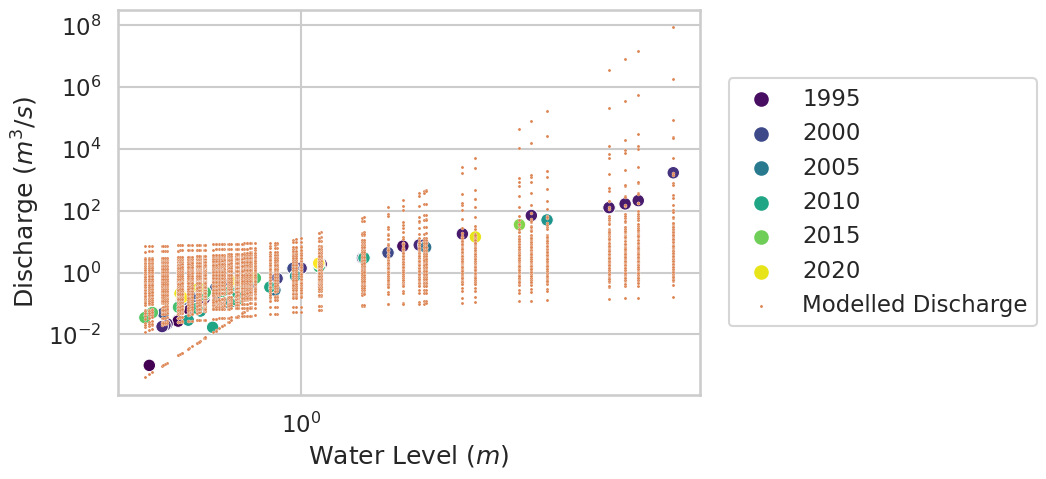

In [ ]:
plot_rc(rcdata,mu=prior_samples['mu'].squeeze())

################################################################################
Priors


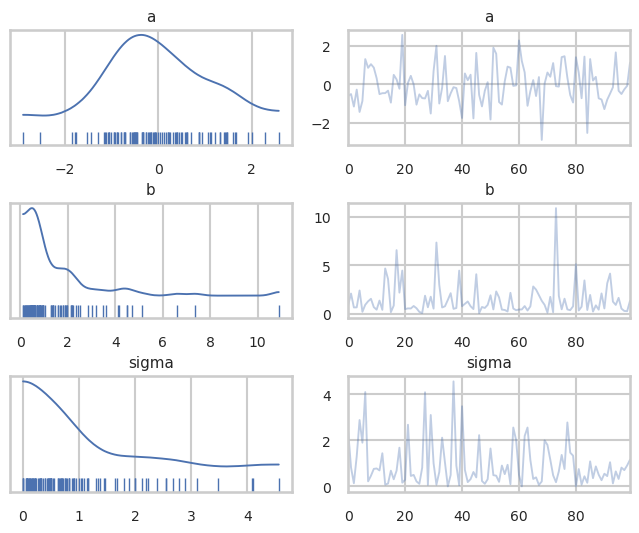

In [ ]:
# and now plot the distributions and the simulated data
print('#'*80)
print('Priors')
priors_ax = az.plot_trace(
    arviz_priors.prior, 
    var_names=['a','b','sigma'],
    figsize=(8,6),
    rug=True,
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

## MCMC Sampling

We will use the No U-Turn Sampler (NUTS) to sample from our posterior distributions. This sampler is popular in many PPLs (Stan, pymc, pyro) and should do the job for us with our mere three parameters. We will sample `num_samples` times form the posterior, with `num_warmup` samples taken and discarded before we start proper.

In [ ]:
# settings 
num_samples = 10000
num_warmup = int(0.25 * num_samples)
ci = 0.68

# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)

# define the sampler - No U-Turn Sampler (NUTS)
kernel = NUTS(linear_model)

# define the mcmc wrapper
mcmc_obj = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)

# now run the sampler for num_samples+burnin
mcmc_obj.run(
    rng_key_, water_level=X, discharge_observed=y
)
mcmc_obj.print_summary()
# get the samples which will form our posterior
samples = mcmc_obj.get_samples()

sample: 100%|██████████| 12500/12500 [00:03<00:00, 3475.47it/s, 3 steps of size 8.17e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.25      0.09     -0.25     -0.39     -0.10   9244.15      1.00
         b      4.18      0.15      4.18      3.94      4.43   7786.99      1.00
     sigma      0.76      0.06      0.75      0.66      0.85   7786.22      1.00

Number of divergences: 0


We will also get predcitive samples (simulations model + error) which will make more sense in the plots below. We add these to an arviz object for easy plotting and calculate the credible intervals.

In [ ]:
# get the samples for predictive uncertainty (our linear model + error)
posterior_predictive = Predictive(linear_model, samples)(
    rng_key_, water_level=X)

# get the mean model prediciton
mean_mu = jnp.mean(posterior_predictive['mu'], axis=0)
# hpdi is used to compute the credible intervals corresponding to ci
hpdi_mu = hpdi(posterior_predictive['mu'], ci)
hpdi_sim_y = hpdi(posterior_predictive['obs'], ci)

arviz_posterior = az.from_numpyro(
    mcmc_obj,
    prior=prior_samples,
    posterior_predictive=posterior_predictive,
)
arviz_posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Plot the posterior distributions for our three parameters and check that they look reasonable. We also want to check the traces (right hand plots) to ensure everything has gone well during the MCMC sampling. Again we won't worry too much about that for this fairly simple case. Notice as well how far our posteriors have deviated from our priors based on the data we have observed.

################################################################################
Posterior


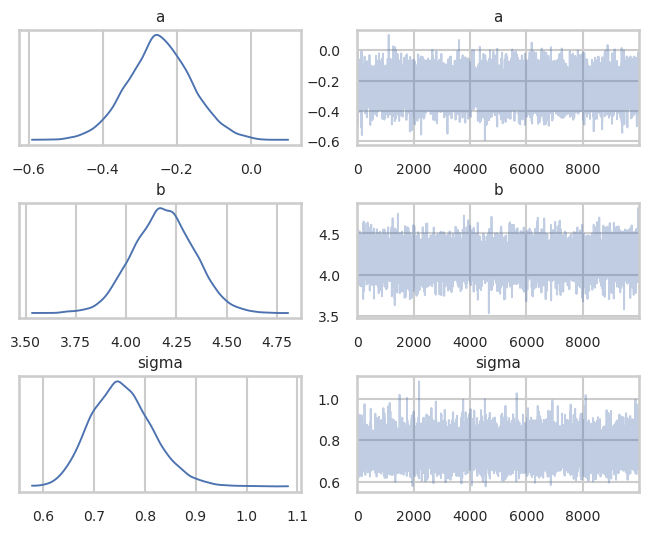

In [ ]:
print('#'*80)
print('Posterior')
az.plot_trace(
    arviz_posterior,
    var_names=['a','b','sigma'],
    figsize=(8,6),
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

## Plot the results

We can now plot our model predictions with uncertainty for our selected credible interval (`ci`) - say 68%. Notice that we plot two uncertainty bands, the first is the credible interval for our linear model (blue bands). Essentially, what are range of slopes and intercepts that linear fit could take, reflecting the posteriors for  parameters $a$ and $b$ as we are uncertain of their exact value. 

However, we also have the $\sigma$ parameter. The predictive uncertainty (credible interval given by the orange bands) incorporates model uncertainty and the error ($\epsilon$) which describes our data (which we have assumed to be of the form $\mathcal{N}(0,\sigma)$). 

Here we are simulating possible values of actual data points, as opposed to just the range of possible linear regression lines. This range reflects the discharge we could expect for a new event if measured by gauging, rather than our modelled prediction of discharge from water level. These bands should include approximately 68% of our data points, i.e. approximately matching the `ci` we have chosen.

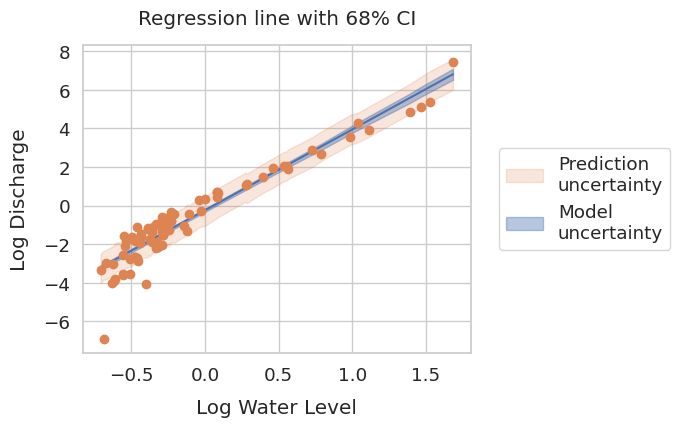

In [ ]:
# Now we will plot the results of our fit
# We need to sort the results so our confidence intervals aren't wonky
sort_idx = jnp.argsort(X)
plot_regression(
    X,y,
    X[sort_idx],mean_mu[sort_idx], 
    hpdi_mu[:,sort_idx], hpdi_sim_y[:,sort_idx], 
    ci
)    